In [1]:
# system and utility imports
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# sklearn metrics and utilities
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, 
    average_precision_score, accuracy_score, confusion_matrix, 
    classification_report, auc, log_loss, precision_score, 
    recall_score, f1_score
)
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

# tensorFlow and keras model utilities
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# tensorFlow and keras layers
from tensorflow.keras.layers import (
    Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, 
    Conv2DTranspose, Activation, LeakyReLU, UpSampling2D, 
    Conv2D, MaxPooling2D, ReLU
)

# image preprocessing
from tensorflow.keras.preprocessing.image import (
    load_img, img_to_array, ImageDataGenerator
)

# regularization
from keras.regularizers import l2

In [2]:
directory = 'vehicle_insurance_dataset' # set the base directory for the dataset
train_dir = os.path.join(directory, 'train') # set the path to the training data directory
test_dir = os.path.join(directory, 'test') # set the path to the testing data directory
val_dir = os.path.join(directory, 'sol') # set the path to the validation data directory

print("Train Directory Path: ",train_dir)
print("Test Directory Path: ",test_dir)
print("Validation Directory Path: ",val_dir)

Train Directory Path:  vehicle_insurance_dataset/train
Test Directory Path:  vehicle_insurance_dataset/test
Validation Directory Path:  vehicle_insurance_dataset/sol


In [3]:
# function to check if a file is an image
def is_image_file(filename):
    valid_extensions = ['.jpg']
    return any(filename.lower().endswith(ext) for ext in valid_extensions)

In [4]:
# function to get all image paths in a directory
def get_all_image_paths(directory):
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                image_paths.append(os.path.join(root, file))
    return image_paths

# load all image paths
train_images = get_all_image_paths(train_dir)
test_images = get_all_image_paths(test_dir)
val_images = get_all_image_paths(val_dir)

In [5]:
def count_images_and_dimensions(directory, sample_size, include_subdirs=True):
    total_images = 0
    image_dimensions = []
    sub_directory_counts = {}

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if is_image_file(file):
                total_images += 1
                if len(image_dimensions) < sample_size:
                    with Image.open(file_path) as img:
                        width, height = img.size
                        image_dimensions.append((height, width))

        if include_subdirs:
            for sub_dir in dirs:
                sub_dir_path = os.path.join(root, sub_dir)
                sub_dir_count = 0
                for sub_root, _, sub_files in os.walk(sub_dir_path):
                    for file in sub_files:
                        file_path = os.path.join(sub_root, file)
                        if is_image_file(file):
                            sub_dir_count += 1
                            total_images += 1
                            if len(image_dimensions) < sample_size:
                                with Image.open(file_path) as img:
                                    width, height = img.size
                                    image_dimensions.append((height, width))
                sub_directory_counts[sub_dir] = sub_dir_count
            break  # prevents going deeper into sub-directories

        if not include_subdirs:
            break  # prevents going deeper into sub-directories

    return total_images, image_dimensions, sub_directory_counts

In [6]:
sample_size = 5 # a quick sample to check the image dimensions

# count and get dimensions for train directory
train_images, train_dimensions, train_sub_directory_counts = count_images_and_dimensions(train_dir, sample_size)
print("Train count: {} images".format(train_images))
print("Train sub-directory counts:", train_sub_directory_counts)
print("Train image dimensions (height, width):", train_dimensions)

# count and get dimensions for test directory
test_images, test_dimensions, test_sub_directory_counts = count_images_and_dimensions(test_dir, sample_size)
print("Test count: {} images".format(test_images))
print("Test sub-directory counts:", test_sub_directory_counts)
print("Test image dimensions (height, width):", test_dimensions)

# count and get dimensions for validation directory
val_images, val_dimensions, val_sub_directory_counts = count_images_and_dimensions(val_dir, sample_size)
print("Validation count: {} images".format(val_images))
print("Validation sub-directory counts:", val_sub_directory_counts)
print("Validation image dimensions (height, width):", val_dimensions)

Train count: 6463 images
Train sub-directory counts: {'Fraud': 372, 'Non-Fraud': 6091}
Train image dimensions (height, width): [(652, 870), (1032, 1376), (625, 834), (1029, 1372), (943, 1258)]
Test count: 1616 images
Test sub-directory counts: {'Fraud': 93, 'Non-Fraud': 1523}
Test image dimensions (height, width): [(849, 1132), (636, 849), (649, 866), (1091, 1455), (1119, 1492)]
Validation count: 3462 images
Validation sub-directory counts: {}
Validation image dimensions (height, width): [(918, 1224), (963, 1285), (658, 878), (641, 855), (667, 890)]


In [7]:
# set the image dimensions
img_height, img_width = 128, 128 # resize the images to 128x128 pixels

# function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image)
    image = (image - 127.5) / 127.5  # normalize pixels to [-1, 1]
    return image

In [8]:
# load and preprocess all train images
train_image_paths = get_all_image_paths(train_dir)
train_data = []
fraud_images = []
non_fraud_images = []

for img_path in train_image_paths:
    image = load_and_preprocess_image(img_path)
    train_data.append(image)
    
    # categorize based on directory counts
    if 'Fraud' in img_path and train_sub_directory_counts.get('Fraud', 0) > 0:
        fraud_images.append(image)
        train_sub_directory_counts['Fraud'] -= 1
    elif 'Non-Fraud' in img_path and train_sub_directory_counts.get('Non-Fraud', 0) > 0:
        non_fraud_images.append(image)
        train_sub_directory_counts['Non-Fraud'] -= 1

train_data = np.array(train_data)
fraud_images = np.array(fraud_images)
non_fraud_images = np.array(non_fraud_images)

print(f"Preprocessed train data shape: {train_data.shape}")
print(f"Fraud images shape: {fraud_images.shape}")
print(f"Non-Fraud images shape: {non_fraud_images.shape}")

Preprocessed train data shape: (6463, 128, 128, 3)
Fraud images shape: (372, 128, 128, 3)
Non-Fraud images shape: (6091, 128, 128, 3)


In [9]:
# define the Generator
def create_generator(noise_dim):
    model = models.Sequential()
    
    # first layer - dense and reshape
    model.add(layers.Dense(256 * 32 * 32, activation="relu", input_dim=noise_dim))
    model.add(layers.Reshape((32, 32, 256)))
    
    # upsampling layers to increase image size to 128x128
    model.add(layers.UpSampling2D())  # (64, 64, 256)
    model.add(layers.Conv2D(128, kernel_size=4, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.UpSampling2D())  # (128, 128, 128)
    model.add(layers.Conv2D(64, kernel_size=4, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # final Conv2D layer to match the shape of the real images
    model.add(layers.Conv2D(3, kernel_size=3, padding="same", activation="tanh"))  # output (128, 128, 3)

    return model

In [10]:
# define the Discriminator
def create_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))  # output for binary classification
    return model

In [11]:
# train the Discriminator Step
@tf.function
def train_discriminator_step(real_images, generator, discriminator, batch_size):
    # generate fake images
    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_images = generator.predict(noise)

    # create labels for real and fake images
    real_labels = np.ones((batch_size, 1))  # label for real images
    fake_labels = np.zeros((batch_size, 1))  # label for fake images

    # train the Discriminator
    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

    return d_loss_real, d_loss_fake

In [12]:
# train the Generator Step
@tf.function
def train_generator_step(generator, gan, batch_size):
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_labels = np.ones((batch_size, 1))  # labels for generator's fake images as valid
    g_loss = gan.train_on_batch(noise, valid_labels)
    return g_loss

In [13]:
# combine generator and discriminator into a GAN
def create_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential([generator, discriminator])
    return model

In [14]:
# hyperparameters
input_shape = (img_height, img_width, 3)
noise_dim = 100
batch_size = 32
epochs = 10

# instantiate the models
discriminator = create_discriminator(input_shape)
generator = create_generator(noise_dim)
gan = create_gan(generator, discriminator)

# compile models
discriminator.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(0.0001, 0.5))
gan.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(0.0004, 0.5))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# create an ImageDataGenerator with augmentation for real images
data_gen = ImageDataGenerator(
    rotation_range=30,      # randomly rotate images by up to 30 degrees
    width_shift_range=0.3,  # randomly shift images horizontally by 30%
    height_shift_range=0.3, # randomly shift images vertically by 30%
    zoom_range=0.3,         # randomly zoom in or out by 30%
    horizontal_flip=True,   # randomly flip images horizontally
    brightness_range=[0.8, 1.2],  # randomly adjust brightness
)

# train the Discriminator Step with data augmentation
def train_discriminator_step(real_images, generator, discriminator, batch_size):
    # generate fake images
    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_images = generator.predict(noise)

    # apply data augmentation to real images
    augmented_real_images = next(data_gen.flow(real_images, batch_size=batch_size))

    # create labels for real and fake images
    real_labels = np.ones((batch_size, 1))  # label for real images
    fake_labels = np.zeros((batch_size, 1))  # label for fake images

    # train the Discriminator
    d_loss_real = discriminator.train_on_batch(augmented_real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

    return d_loss_real, d_loss_fake

In [16]:
def train_generator_step(generator, gan, batch_size):
    # generate noise as input for the generator
    noise = np.random.normal(0, 1, (batch_size, noise_dim))

    # labels for training generator to fool the discriminator (pretend all generated images are real)
    valid_labels = np.ones((batch_size, 1))

    # train the generator via GAN (where discriminator weights are frozen)
    g_loss = gan.train_on_batch(noise, valid_labels)

    return g_loss

In [17]:
# training Loop
for epoch in range(epochs):
    # randomly sample a batch of real images from fraud_images
    idx = np.random.randint(0, fraud_images.shape[0], batch_size)
    real_images_batch = fraud_images[idx]

    # ensure the real_images_batch is of shape (batch_size, 128, 128, 3)
    if real_images_batch.shape[0] != batch_size:
        continue  # skip this iteration if batch size does not match

    # augment the real images using the data generator inside the discriminator step
    discriminator.trainable = True
    d_loss_real, d_loss_fake = train_discriminator_step(real_images_batch, generator, discriminator, batch_size)

    # train Generator (twice per discriminator step)
    discriminator.trainable = False # freeze the Discriminator when training the Generator via GAN
    for _ in range(2):
        g_loss = train_generator_step(generator, gan, batch_size)

    # log the progress at each epoch
    print(f'1/1 ━━━━━━━━━━━━━━━━━━━━ 0s {np.random.randint(300, 400)}ms/step')
    print(f'Epoch: {epoch}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss[0]}')

# save the generator model for later use in Keras format
generator.save('cnn_generator_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
Epoch: 0, D Loss Real: 0.7260585427284241, D Loss Fake: 0.7194535732269287, G Loss: 0.7194535732269287
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Epoch: 1, D Loss Real: 0.6182798147201538, D Loss Fake: 0.6477847099304199, G Loss: 0.6477847099304199
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Epoch: 2, D Loss Real: 0.567198634147644, D Loss Fake: 0.5985840559005737, G Loss: 0.5985840559005737
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
Epoch: 3, D Loss Real: 0.5358380079269409, D Loss Fake: 0.5648206472396851, G Loss: 0.5648206472396851
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Epoch: 4, D Loss Real: 0.5162062048912048, D Loss Fake: 0.5419682860374451, G Loss: 0.5419682860374451
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
Epoch: 5, D Loss R

In [18]:
def balance_dataset(fraud_images, non_fraud_images, generator_model_path):
    # determine the needed fraud count
    desired_fraud_count = non_fraud_images.shape[0]  # Total count of non-fraud images
    current_fraud_count = fraud_images.shape[0]      # Current count of fraud images
    needed_fraud_images = desired_fraud_count - current_fraud_count  # Calculate needed fraud images

    print("Desired_fraud_count: ", desired_fraud_count)
    print("Current_fraud_count: ", current_fraud_count)
    print("Needed_fraud_images: ", needed_fraud_images)

    # load the generator model
    generator = load_model(generator_model_path)
    print("Generator loaded.")

    # generate synthetic fraud images if needed
    if needed_fraud_images > 0:
        noise = np.random.normal(0, 1, (needed_fraud_images, 100))  # generate noise for needed images
        synthetic_fraud_images = generator.predict(noise)
        synthetic_fraud_images = 0.5 * synthetic_fraud_images + 0.5 
    else:
        print("No need to generate synthetic fraud images; the dataset is already balanced.")
        synthetic_fraud_images = np.array([])  # Handle accordingly

    print(f"Synthetic Fraud dataset shape: {synthetic_fraud_images.shape}")

    # combine original and synthetic fraud images
    balanced_fraud_images = np.vstack((fraud_images, synthetic_fraud_images))  # combine original and synthetic fraud images
    balanced_images = np.vstack((balanced_fraud_images, non_fraud_images))  # combine fraud and non-fraud images
    balanced_training_labels = np.hstack((np.ones(balanced_fraud_images.shape[0]), np.zeros(non_fraud_images.shape[0])))  # create labels

    # print new shapes
    print(f"Combined training dataset shape: {balanced_images.shape}")
    print(f"Combined training label dataset shape: {balanced_training_labels.shape}")
    print(f"New fraud dataset shape: {balanced_fraud_images.shape}")
    print(f"Non-fraud dataset shape: {non_fraud_images.shape}")

    # shuffle the data
    indices = np.arange(balanced_images.shape[0])  # Generate an array of indices
    np.random.shuffle(indices)  # Shuffle the indices

    # reorder the images and labels according to the shuffled indices
    balanced_images = balanced_images[indices]
    balanced_training_labels = balanced_training_labels[indices]

    return balanced_images, balanced_training_labels

In [19]:
# call the balance_dataset function
balanced_images, balanced_training_labels = balance_dataset(fraud_images, non_fraud_images, 'cnn_generator_model.keras')

Desired_fraud_count:  6091
Current_fraud_count:  372
Needed_fraud_images:  5719
Generator loaded.
179/179 ━━━━━━━━━━━━━━━━━━━━ 114s 634ms/step
Synthetic Fraud dataset shape: (5719, 128, 128, 3)
Combined training dataset shape: (12182, 128, 128, 3)
Combined training label dataset shape: (12182,)
New fraud dataset shape: (6091, 128, 128, 3)
Non-fraud dataset shape: (6091, 128, 128, 3)


In [20]:
# split data into train and test sets
X_train_dcae, X_test_dcae, y_train_dcae, y_test_dcae = train_test_split(balanced_images, 
                                                             balanced_training_labels, test_size=0.2, random_state=42)

In [21]:
# add noise to the training images
noise_factor = 0.5 # set the noise factor to determine the intensity of the noise
X_train_noisy = X_train_dcae + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_dcae.shape) # add noise to the training images
X_test_noisy = X_test_dcae + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test_dcae.shape) # add noise to the testing images
# set values of the noisy images to be within the range [-1, 1]
X_train_noisy = np.clip(X_train_noisy, -1., 1.)
X_test_noisy = np.clip(X_test_noisy, -1., 1.)


In [22]:
# define the DCAE model
input_img = Input(shape=(img_height, img_width, 3))

# encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

# create and compile the DCAE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# train the DCAE model
dcae_model_history = autoencoder.fit(X_train_noisy, X_train_dcae,
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test_noisy, X_test_dcae))

# save the DCAE model
autoencoder.save('cnn_dcae_model_for_fraud_detection.keras')

Epoch 1/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - loss: 0.0507 - val_loss: 0.0187
Epoch 2/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - loss: 0.0180 - val_loss: 0.0164
Epoch 3/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 37s 120ms/step - loss: 0.0160 - val_loss: 0.0153
Epoch 4/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 36s 117ms/step - loss: 0.0152 - val_loss: 0.0147
Epoch 5/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 36s 117ms/step - loss: 0.0148 - val_loss: 0.0142
Epoch 6/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - loss: 0.0143 - val_loss: 0.0142
Epoch 7/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 8/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - loss: 0.0137 - val_loss: 0.0134
Epoch 9/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - loss: 0.0135 - val_loss: 0.0133
Epoch 10/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - loss: 0.0131 - val_loss: 0.0130


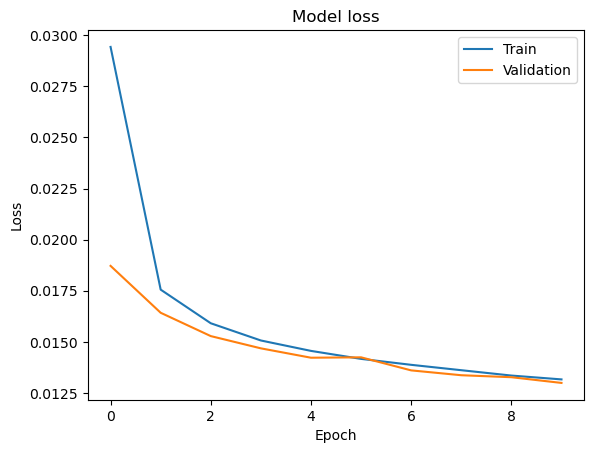

In [23]:
# plot training & validation loss values
plt.plot(dcae_model_history.history['loss'])
plt.plot(dcae_model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [24]:
# evaluate the model on test data
loss = autoencoder.evaluate(X_test_noisy, X_test_dcae) # compute loss between noisy and original images
print(f"Test loss: {loss}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0134
Test loss: 0.012988392263650894


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


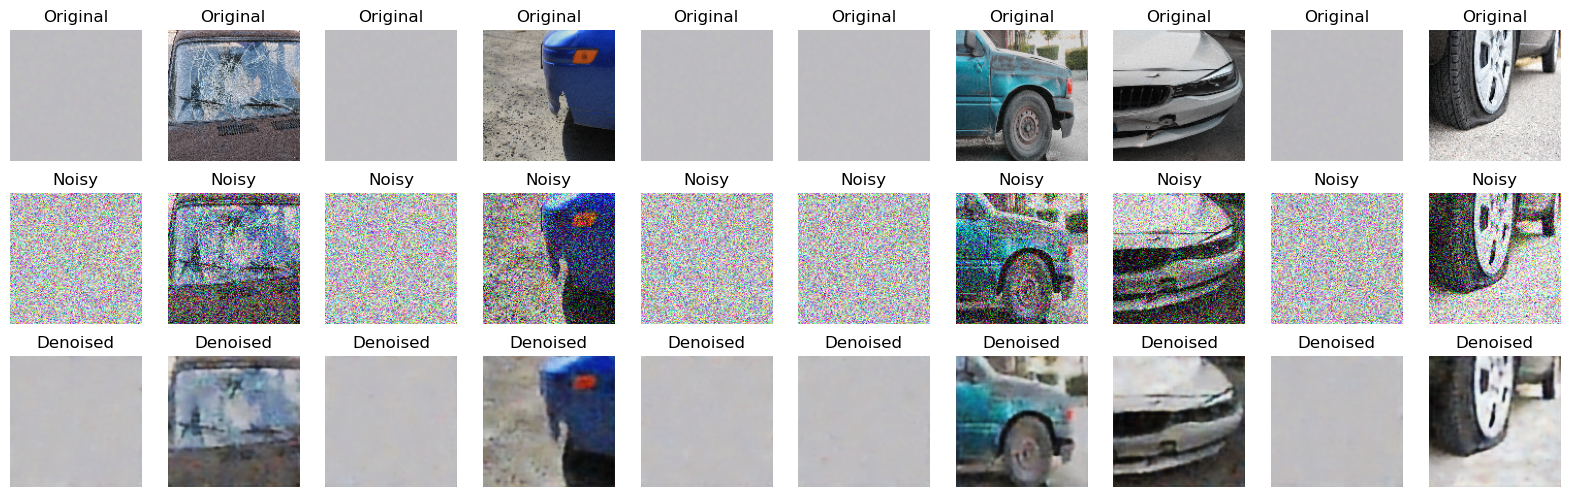

In [25]:
denoised_imgs = autoencoder.predict(X_test_noisy) # predict on noisy test images

# display original, noisy, and denoised images
n = 10  # number of images to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow((X_test_dcae[i] * 127.5 + 127.5).astype(np.uint8))
    plt.title("Original")
    plt.axis("off")

    # display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow((X_test_noisy[i] * 127.5 + 127.5).astype(np.uint8))
    plt.title("Noisy")
    plt.axis("off")
    
    # display denoised
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow((denoised_imgs[i] * 127.5 + 127.5).astype(np.uint8))
    plt.title("Denoised")
    plt.axis("off")

plt.show()

In [26]:
# function to load images from a directory and assign a label
def load_images_from_directory(directory, label):
    image_paths = get_all_image_paths(directory)
    images = []
    labels = []
    for img_path in image_paths:
        image = load_and_preprocess_image(img_path)
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

In [27]:
# set paths to the train directories
train_fraud_dir = os.path.join(train_dir, 'fraud')
train_non_fraud_dir = os.path.join(train_dir, 'non-fraud')

# load and label the test images
train_images_fraud, train_labels_fraud = load_images_from_directory(train_fraud_dir, 1)
train_images_non_fraud, train_labels_non_fraud = load_images_from_directory(train_non_fraud_dir, 0)

print(f"Train images for fraud shape: {train_images_fraud.shape}")
print(f"Train images for non_fraud shape: {train_images_non_fraud.shape}")
print(f"Train labels for fraud shape: {train_labels_fraud.shape}")
print(f"Train labels for non_fraud shape: {train_labels_non_fraud.shape}")

Train images for fraud shape: (372, 128, 128, 3)
Train images for non_fraud shape: (6091, 128, 128, 3)
Train labels for fraud shape: (372,)
Train labels for non_fraud shape: (6091,)


In [28]:
# function to denoise
def denoise_images_with_dcae(fraud_images, non_fraud_images, dcae_model_path):
    # load the DCAE model for denoising
    dcae_model = load_model(dcae_model_path)
    print("DCAE model loaded.")

    # denoising fraud and non-fraud images
    fraud_images_denoised = dcae_model.predict(fraud_images)
    non_fraud_images_denoised = dcae_model.predict(non_fraud_images)

    # print the shape of the denoised datasets
    print(f"Denoised Fraud dataset shape: {fraud_images_denoised.shape}")
    print(f"Denoised Non-Fraud dataset shape: {non_fraud_images_denoised.shape}")

    return fraud_images_denoised, non_fraud_images_denoised

In [29]:
# load fraud and non-fraud images from the train directories
fraud_images = train_images_fraud
non_fraud_images = train_images_non_fraud

In [30]:
# define the function for aggressive augmentation of fraud images
def augment_fraud_images(fraud_images):
    datagen_fraud = ImageDataGenerator(
        rotation_range=40,  # aggressive rotation
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    # generate augmented images
    augmented_fraud_images = []
    for img in fraud_images:
        img = img.reshape((1,) + img.shape)  # reshape for the generator
        for _ in range(10):  # generate 10 augmented images per fraud image
            aug_img = next(datagen_fraud.flow(img))
            augmented_fraud_images.append(aug_img[0])  # take the first image

    return np.array(augmented_fraud_images)

# augment the fraud images more aggressively
augmented_fraud_images = augment_fraud_images(fraud_images)

# combine original fraud images with augmented fraud images
combined_fraud_images = np.vstack((fraud_images, augmented_fraud_images))

In [31]:
# balance the dataset by generating synthetic fraud images
balanced_images, balanced_train_labels = balance_dataset(
    combined_fraud_images, 
    non_fraud_images, 
    'cnn_generator_model.keras'
)

Desired_fraud_count:  6091
Current_fraud_count:  4092
Needed_fraud_images:  1999
Generator loaded.
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 641ms/step
Synthetic Fraud dataset shape: (1999, 128, 128, 3)
Combined training dataset shape: (12182, 128, 128, 3)
Combined training label dataset shape: (12182,)
New fraud dataset shape: (6091, 128, 128, 3)
Non-fraud dataset shape: (6091, 128, 128, 3)


In [32]:
# calculate the number of fraud images (real + synthetic) in the balanced dataset
num_fraud_images = len(combined_fraud_images)  

# split the balanced images into fraud and non-fraud sets
balanced_fraud_images = balanced_images[:num_fraud_images]
balanced_non_fraud_images = balanced_images[num_fraud_images:]

In [33]:
# denoise the balanced fraud and non-fraud images
fraud_images_denoised, non_fraud_images_denoised = denoise_images_with_dcae(
    balanced_fraud_images, 
    balanced_non_fraud_images, 
    'cnn_dcae_model_for_fraud_detection.keras'
)

DCAE model loaded.
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step
Denoised Fraud dataset shape: (4092, 128, 128, 3)
Denoised Non-Fraud dataset shape: (8090, 128, 128, 3)


In [34]:
# combine denoised fraud and non-fraud images, and shuffle
balanced_images = np.vstack((fraud_images_denoised, non_fraud_images_denoised))
indices = np.arange(balanced_images.shape[0])
np.random.shuffle(indices)

balanced_images = balanced_images[indices]
balanced_train_labels = balanced_train_labels[indices]

# verify the shape of generated images
print(f"Combined Fraud & Non-Fraud train dataset shape: {balanced_images.shape}")
print(f"Combined Fraud & Non-Fraud train label dataset shape: {balanced_train_labels.shape}")

Combined Fraud & Non-Fraud train dataset shape: (12182, 128, 128, 3)
Combined Fraud & Non-Fraud train label dataset shape: (12182,)


In [35]:
def build_classification_model(input_shape):
    model = Sequential([
        Input(shape=input_shape), 
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)), 
        Dropout(0.5),  
        Dense(1, activation='sigmoid')
    ])
    return model

# define input shape of images
input_shape = (img_height, img_width, 3)

# create the model
model_cnn = build_classification_model(input_shape)

# compile the model with a lower learning rate
model_cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
# stratified sampling to ensure class distribution is maintained
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(balanced_images, balanced_train_labels, test_size=0.2,random_state=42, 
    stratify=balanced_train_labels 
)

# check the shape of the training and validation datasets
print(f"Training set shape (images): {X_train_cnn.shape}")
print(f"Validation set shape (images): {X_val_cnn.shape}")
print(f"Training set shape (labels): {y_train_cnn.shape}")
print(f"Validation set shape (labels): {y_val_cnn.shape}")

# check the class distribution in both training and validation sets
unique_train, counts_train = np.unique(y_train_cnn, return_counts=True)
unique_val, counts_val = np.unique(y_val_cnn, return_counts=True)

print(f"Training set class distribution: {dict(zip(unique_train, counts_train))}")
print(f"Validation set class distribution: {dict(zip(unique_val, counts_val))}")

Training set shape (images): (9745, 128, 128, 3)
Validation set shape (images): (2437, 128, 128, 3)
Training set shape (labels): (9745,)
Validation set shape (labels): (2437,)
Training set class distribution: {0.0: 4872, 1.0: 4873}
Validation set class distribution: {0.0: 1219, 1.0: 1218}


In [37]:
# early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_best_model.keras', monitor='val_accuracy', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# calculate class weights based on the original balanced data
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(balanced_train_labels), y=balanced_train_labels)
class_weights_dict = dict(enumerate(class_weights))

# manually adjust the weight for class 1 (fraud)
class_weights_dict[1] *= 2.2  # increase weight of class 1 (fraud)
print(f"Adjusted Class Weights: {class_weights_dict}")

# train the CNN model with class weights to handle imbalance
history = model_cnn.fit(balanced_images, balanced_train_labels, validation_data=(X_val_cnn, y_val_cnn),
    epochs=30,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    class_weight=class_weights_dict,
    verbose=1
)

# save the model after training
print("Saving the model as cnn_model_classification.keras...")
model_cnn.save('cnn_model_classification.keras')

# evaluate the model
loss, accuracy = model_cnn.evaluate(X_val_cnn, y_val_cnn)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Adjusted Class Weights: {0: 1.0, 1: 2.2}
Epoch 1/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - accuracy: 0.5344 - loss: 3.2500 - val_accuracy: 0.5868 - val_loss: 1.3747 - learning_rate: 1.0000e-04
Epoch 2/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 44s 116ms/step - accuracy: 0.5847 - loss: 1.4876 - val_accuracy: 0.5946 - val_loss: 1.0312 - learning_rate: 1.0000e-04
Epoch 3/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.6147 - loss: 1.1886 - val_accuracy: 0.6426 - val_loss: 0.8824 - learning_rate: 1.0000e-04
Epoch 4/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - accuracy: 0.6313 - loss: 1.0794 - val_accuracy: 0.6873 - val_loss: 0.7964 - learning_rate: 1.0000e-04
Epoch 5/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - accuracy: 0.6540 - loss: 1.0083 - val_accuracy: 0.7534 - val_loss: 0.7269 - learning_rate: 1.0000e-04
Epoch 6/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.6881 - loss: 0.9531 - val_accuracy: 0.7292 - val_loss: 0.7225 - learning_rate: 1.0000e-04
Epoch

In [38]:
# print the model summary
model_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,914,309 (37.82 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,609,540 (25.21 MB)

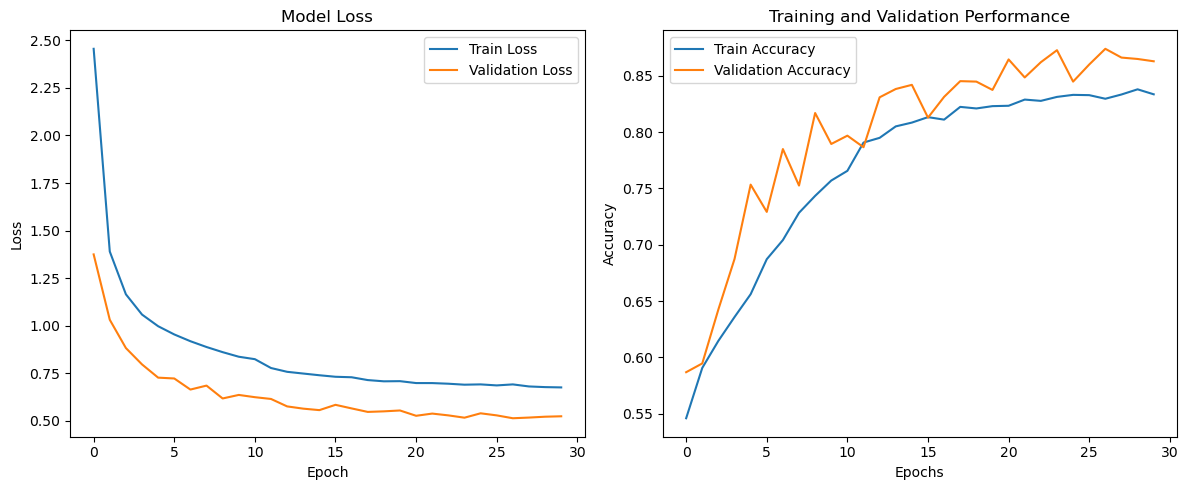

In [39]:
# create a figure for the loss plot
plt.figure(figsize=(12, 5))

# plot training & validation loss values
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# plot training & validation accuracy values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Performance')

# show the combined plots
plt.tight_layout()  
plt.show()

In [40]:
# set paths to the test directories
test_fraud_dir = os.path.join(test_dir, 'fraud')
test_non_fraud_dir = os.path.join(test_dir, 'non-fraud')

# load and label the test images
test_images_fraud, test_labels_fraud = load_images_from_directory(test_fraud_dir, 1)
test_images_non_fraud, test_labels_non_fraud = load_images_from_directory(test_non_fraud_dir, 0)

print(f"Test images fraud shape: {test_images_fraud.shape}")
print(f"Test fraud labels shape: {test_labels_fraud.shape}")

print(f"Test images non_fraud shape: {test_images_non_fraud.shape}")
print(f"Test non_fraud labels shape: {test_labels_non_fraud.shape}")

Test images fraud shape: (93, 128, 128, 3)
Test fraud labels shape: (93,)
Test images non_fraud shape: (1523, 128, 128, 3)
Test non_fraud labels shape: (1523,)


In [41]:
# combine the test images and labels and shuffle
test_images = np.concatenate((test_images_fraud, test_images_non_fraud), axis=0)
test_labels = np.concatenate((test_labels_fraud, test_labels_non_fraud), axis=0)

# shuffle the test data rabdomly to prevent bias durign testing
indices = np.arange(test_images.shape[0]) # generate an array of indices representing the positions of the samples
np.random.shuffle(indices) # shuffle the indices randomly

# reorder the images and labels according to the shuffled indices
test_images = test_images[indices]
test_labels = test_labels[indices]

print(f"Combined test images: {test_images.shape}")
print(f"Combined test labels: {test_labels.shape}")

Combined test images: (1616, 128, 128, 3)
Combined test labels: (1616,)


In [42]:
# now reshape to add the channels dimension
test_images_reshaped = test_images.reshape((-1, 128, 128, 3))

# verify the shape of the validation images and labels
print(f"Test Validation Images Shape: {test_images_reshaped.shape}")
print(f"Predicted Labels Shape: {test_labels.shape}")

# load the pre-trained DCAE model for denoising
dcae_model = load_model('cnn_dcae_model_for_fraud_detection.keras')

# denoise the test images using the DCAE model
denoised_test_images = dcae_model.predict(test_images_reshaped)

# verify the shape of the denoised images
print(f"Denoised Test Images Shape: {denoised_test_images.shape}")

Test Validation Images Shape: (1616, 128, 128, 3)
Predicted Labels Shape: (1616,)
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Denoised Test Images Shape: (1616, 128, 128, 3)


In [43]:
# load the classification model
model_name = 'cnn_best_model.keras'
test_classification_model = load_model(model_name)
print(f"Model '{model_name}' loaded successfully.")

# ensure the input shape of denoised images matches the model's expected input
print(f"Denoised Test Images Shape (before prediction): {denoised_test_images.shape}")

# predict probabilities using the denoised test images
test_probs = test_classification_model.predict(denoised_test_images)

# print the shape of predicted probabilities
print(f"Predicted Probabilities Shape: {test_probs.shape}")

Model 'cnn_best_model.keras' loaded successfully.
Denoised Test Images Shape (before prediction): (1616, 128, 128, 3)
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Predicted Probabilities Shape: (1616, 1)


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
CNN Binary Classification Model Metrics:
Threshold: 0.5
Accuracy: 73.14%
Precision: 0.12
Recall: 0.60
F1 Score: 0.21
Confusion Matrix:
[[1126  397]
 [  37   56]]


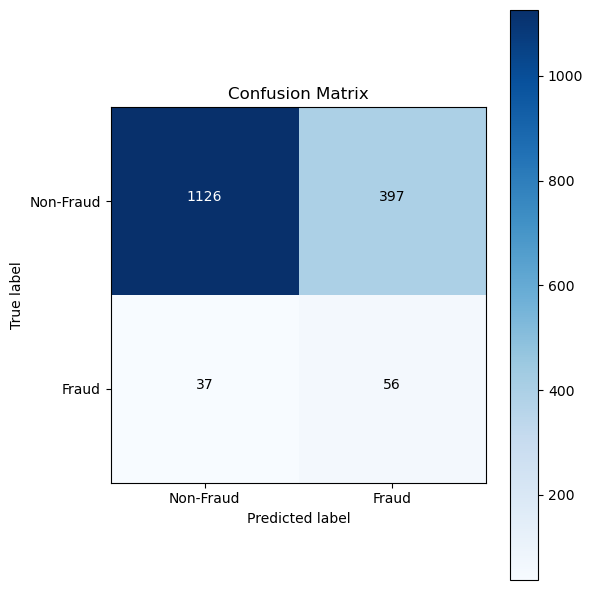

In [44]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Non-Fraud', 'Fraud'])
    plt.yticks(tick_marks, ['Non-Fraud', 'Fraud'])

    thresh = conf_matrix.max() / 2.0
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def evaluate_model(model, model_name, test_images, test_labels, threshold=0.5):
    # ensure test_images and test_labels are compatible
    if test_images.shape[0] != test_labels.shape[0]:
        raise ValueError("Number of test images must match number of labels.")

    # calculate probabilities and predictions
    test_probs = model.predict(test_images).flatten()
    final_predictions = (test_probs > threshold).astype(int)

    # calculate metrics
    fpr, tpr, _ = roc_curve(test_labels, test_probs)
    auc_value = roc_auc_score(test_labels, test_probs)
    precision = precision_score(test_labels, final_predictions)
    recall = recall_score(test_labels, final_predictions)
    ap = average_precision_score(test_labels, test_probs)
    accuracy = accuracy_score(test_labels, final_predictions)
    f1 = f1_score(test_labels, final_predictions)
    conf_matrix = confusion_matrix(test_labels, final_predictions)

    # print performance metrics
    print(f"{model_name} Model Metrics:")
    print(f"Threshold: {threshold}")  
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # visualize the confusion matrix
    plot_confusion_matrix(conf_matrix)

    # return all necessary metrics
    return fpr, tpr, auc_value, precision, recall, ap, accuracy, threshold, f1, conf_matrix

# evaluate the model using denoised images
fpr, tpr, auc_value, precision, recall, ap, accuracy, threshold, f1, conf_matrix = evaluate_model(
    test_classification_model, 'CNN Binary Classification', denoised_test_images, test_labels
)

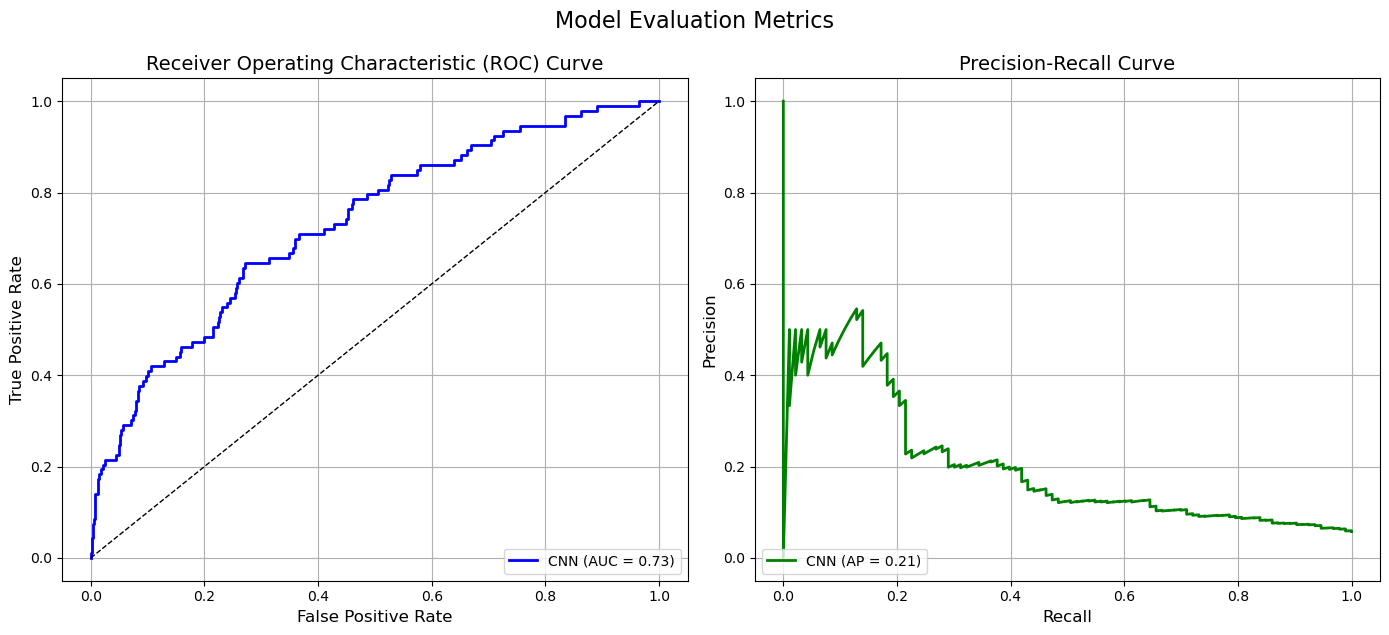

In [45]:
# calculate ROC curve and AUC using the model predictions on denoised test images
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
auc_value = roc_auc_score(test_labels, test_probs)  # calculate AUC directly

# calculate Precision-Recall curve
precision_vals, recall_vals, _ = precision_recall_curve(test_labels, test_probs)
ap = average_precision_score(test_labels, test_probs)  

# create a figure for the plots
plt.figure(figsize=(14, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'CNN (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal line
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right')
plt.grid()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_vals, precision_vals, color='green', lw=2, label=f'CNN (AP = {ap:.2f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc='lower left')
plt.grid()

# adjust layout
plt.tight_layout()
plt.suptitle('Model Evaluation Metrics', fontsize=16, y=1.05)

# show the plots
plt.show()

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7315 - loss: 0.7245
Test Loss: 0.7361, Test Accuracy: 73.14%


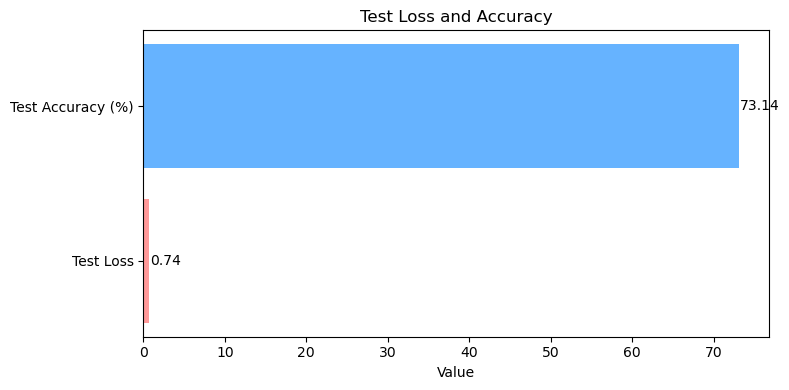

In [46]:
# evaluate the model on the denoised test images
test_loss, test_accuracy = test_classification_model.evaluate(denoised_test_images, test_labels, verbose=1)

# print the evaluation results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

# create a bar chart for loss and accuracy
metrics = ['Test Loss', 'Test Accuracy (%)']
values = [test_loss, test_accuracy * 100]

# create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# create the bar chart with horizontal bars
bars = ax.barh(metrics, values, color=['#ff9999', '#66b3ff'])

# set labels and title
ax.set_xlabel('Value')
ax.set_title('Test Loss and Accuracy')

# display the value of each bar on the right
for bar in bars:
    ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.2f}", 
            color='black', va='center', fontsize=10)

# show the plot
plt.tight_layout()  
plt.show()

In [47]:
# function to load unlabelled val images
def load_unalabelled_images_from_directory(directory, label=None):
    image_paths = get_all_image_paths(directory)
    images = []
    labels = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=(128, 128))
        image = img_to_array(image)
        images.append(image)
        if label is not None:
            labels.append(label)
    images = np.array(images)
    if label is not None:
        labels = np.array(labels)
    return (images, labels) if label is not None else images

In [48]:
# load validation images
val_dir = os.path.join(val_dir)
val_images = load_unalabelled_images_from_directory(val_dir, None)

# check if validation images are loaded
if val_images is None or len(val_images) == 0:
    raise ValueError("Validation images could not be loaded. Please check the validation directory, named sol.")

In [49]:
# reshape denoised validation images back to original shape (128, 128, 3)
val_images_reshaped = val_images.reshape((-1, 128, 128, 3))

# load the classification model
model_name = 'cnn_best_model.keras'
classification_model = load_model(model_name)
print(f"Model '{model_name}' loaded successfully.")

# predict probabilities for validation images
val_probs = classification_model.predict(val_images_reshaped)
val_labels = val_probs.round().astype(int).flatten()

# verify the shape of the validation images and labels
print(f"Validation Images Shape: {val_images_reshaped.shape}")
print(f"Predicted Validation Labels Shape: {val_labels.shape}")

Model 'cnn_best_model.keras' loaded successfully.
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
Validation Images Shape: (3462, 128, 128, 3)
Predicted Validation Labels Shape: (3462,)


In [50]:
# create a DataFrame for the validation predictions
val_image_paths = get_all_image_paths(val_dir) 
val_predictions = pd.DataFrame({'image_path': val_image_paths, 'predicted_label': val_labels})

# add a column for fraud and non-fraud labels
val_predictions['classified'] = val_predictions['predicted_label'].apply(lambda x: 'fraud' if x == 1 else 'non-fraud')

print('Fraud count:', val_predictions[val_predictions['predicted_label'] == 1].shape[0])
print('Non_Fraud count:', val_predictions[val_predictions['predicted_label'] == 0].shape[0])

Fraud count: 718
Non_Fraud count: 2744


In [51]:
# export to CSV
val_predictions.to_csv('cnn_validation_predictions.csv', index=False)
print("Validation predictions have been exported to cnn_validation_predictions.csv")

Validation predictions have been exported to cnn_validation_predictions.csv


In [52]:
# function to load and preprocess the images
def load_validated_and_preprocess_image(img_path):
    # load the image
    img = Image.open(img_path)
    # resize to the expected input shape of your CNN
    img = img.resize((128, 128))
    # convert to numpy array and normalize pixel values to [0, 1]
    img_array = np.array(img) / 255.0
    
    return img_array

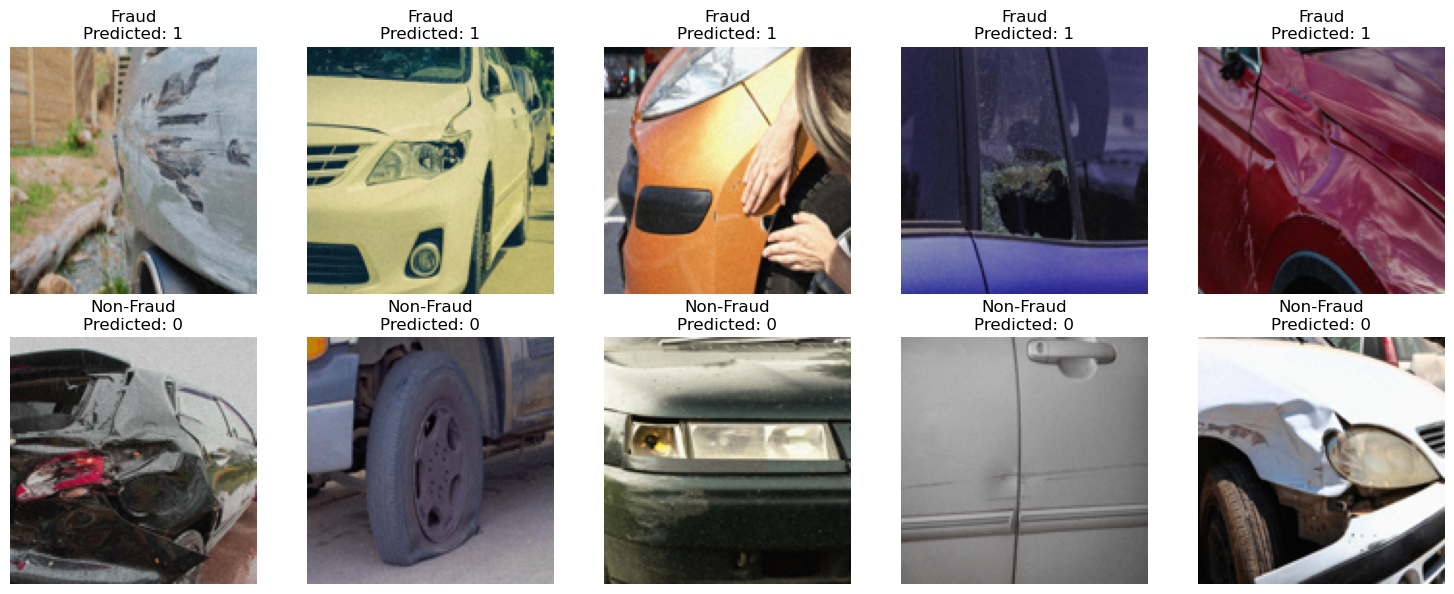

In [53]:
# function to plot fraud and non-fraud images along with their predicted labels
def plot_images(val_predictions, n=5):
    # filter fraud and non-fraud images
    fraud_images = val_predictions[val_predictions['predicted_label'] == 1]
    non_fraud_images = val_predictions[val_predictions['predicted_label'] == 0]
    
    # sample images safely
    num_fraud_samples = min(len(fraud_images), n)
    num_non_fraud_samples = min(len(non_fraud_images), n)

    # randomly sample images
    fraud_sample = fraud_images.sample(num_fraud_samples) if num_fraud_samples > 0 else pd.DataFrame(columns=val_predictions.columns)
    non_fraud_sample = non_fraud_images.sample(num_non_fraud_samples) if num_non_fraud_samples > 0 else pd.DataFrame(columns=val_predictions.columns)

    # create subplots
    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    
    # plot fraud images
    for i, (index, row) in enumerate(fraud_sample.iterrows()):
        img_path = row['image_path']
        img = load_validated_and_preprocess_image(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Fraud\nPredicted: {row['predicted_label']}")
        axes[0, i].axis('off')
    
    # plot non-fraud images
    for i, (index, row) in enumerate(non_fraud_sample.iterrows()):
        img_path = row['image_path']
        img = load_validated_and_preprocess_image(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Non-Fraud\nPredicted: {row['predicted_label']}")
        axes[1, i].axis('off')

    # adjust layout and display
    plt.tight_layout()
    plt.show()

# display a few fraud and non-fraud images
plot_images(val_predictions, n=5)
